##Vamos começar instalando e importando oque será necessario


In [2]:
# Instalar as dependências
!pip install ultralytics opencv-python matplotlib gdown


In [6]:
#Importanto o dataset
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("landrykezebou/vcor-vehicle-color-recognition-dataset")

print("Path to dataset files:", path)

  Using cached kagglehub-0.3.6-py3-none-any.whl.metadata (30 kB)
Using cached kagglehub-0.3.6-py3-none-any.whl (51 kB)
Path to dataset files: C:\Users\guilh\.cache\kagglehub\datasets\landrykezebou\vcor-vehicle-color-recognition-dataset\versions\1


In [10]:
import shutil
import os

# Caminho onde o dataset foi baixado
original_path = r"C:\Users\guilh\.cache\kagglehub\datasets\landrykezebou\vcor-vehicle-color-recognition-dataset\versions\1"

# Novo caminho onde você deseja salvar o dataset
new_path = r"C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset"

# Mover o dataset para o novo diretório
shutil.move(original_path, new_path)

print(f"Dataset movido para: {new_path}")

Dataset movido para: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset


## Verificando o dataset e adptando o para o modelo Yolo


In [16]:
import os

# Verificar a estrutura do dataset
dataset_path = r"C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1"
for root, dirs, files in os.walk(dataset_path):
   print(f"Root: {root}")
   print(f"Dirs: {dirs}")
   print(f"Files: {files[:5]}")  # Mostrar apenas os 5 primeiros arquivos

Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1
Dirs: ['test', 'train', 'val']
Files: []
Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1\test
Dirs: ['beige', 'black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'tan', 'white', 'yellow']
Files: []
Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1\test\beige
Dirs: []
Files: ['02e37c0e56.jpg', '05aeb6ddec.jpg', '0b01008bee.jpg', '0c3bb456ee.jpg', '0e491569c8.jpg']
Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1\test\black
Dirs: []
Files: ['019301dea8.jpg', '070ed15b67.jpg', '0ea1f11a35.jpg', '10f08e9178.jpg', '1e01b3da2b.jpg']
Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1\test\blue
Dirs: []
Files: ['00be3db68c.jpg', '01401b6d76.jpg', '0440c22324.jpg', '05ed632b0c.jpg', '080863fed8.jpg']
Root: C:\Users\guilh\OneDrive\Documentos\GitHub\car-c

In [18]:
import os

def load_dataset(base_path):
    data = []
    for label in os.listdir(base_path):
        label_path = os.path.join(base_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith('jpg'):
                    file_path = os.path.join(label_path, file)
                    data.append((file_path, label))
    return data

#base path appra o conjunto de treino
train_base_path = r"C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1\train"
train_data = load_dataset(train_base_path)

print(train_data[:2])

[('C:\\Users\\guilh\\OneDrive\\Documentos\\GitHub\\car-color-recognition\\dataset\\1\\train\\beige\\00ecfeedea.jpg', 'beige'), ('C:\\Users\\guilh\\OneDrive\\Documentos\\GitHub\\car-color-recognition\\dataset\\1\\train\\beige\\012d5b3f87.jpg', 'beige')]


In [29]:
import os
import shutil
from PIL import Image

# Diretório raiz do dataset
dataset_dir = r"C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\dataset\1"

# Classes permitidas
allowed_classes = ['white', 'black', 'red', 'yellow', 'silver', 'blue', 'green']
class_to_id = {cls: idx for idx, cls in enumerate(allowed_classes)}

# Diretórios de destino
output_dir = "yolo_dataset"
image_dir = os.path.join(output_dir, "images")
label_dir = os.path.join(output_dir, "labels")

train_img_dir = os.path.join(image_dir, "train")
val_img_dir = os.path.join(image_dir, "val")
test_img_dir = os.path.join(image_dir, "test")
train_label_dir = os.path.join(label_dir, "train")
val_label_dir = os.path.join(label_dir, "val")
test_label_dir = os.path.join(label_dir, "test")

# Criar pastas
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)

# Função para transformar anotações em formato YOLO
def create_yolo_label(image_path, label, label_dir):
    with Image.open(image_path) as img:
        width, height = img.size

    # Coordenadas normalizadas
    class_id = class_to_id[label]
    center_x, center_y = 0.5, 0.5
    obj_width, obj_height = 1.0, 1.0

    # Criar arquivo de anotação
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    label_path = os.path.join(label_dir, f"{image_name}.txt")
    with open(label_path, "w") as f:
        f.write(f"{class_id} {center_x} {center_y} {obj_width} {obj_height}\n")

# Inicializar dados e processar
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(dataset_dir, split)
    for label in os.listdir(split_dir):
        if label not in allowed_classes:
            continue  # Ignorar classes não permitidas

        label_dir = os.path.join(split_dir, label)
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)

            if "train" in image_path:
                dest_img_dir = train_img_dir
                dest_label_dir = train_label_dir
            elif "val" in image_path:
                dest_img_dir = val_img_dir
                dest_label_dir = val_label_dir
            elif "test" in image_path:
                dest_img_dir = test_img_dir
                dest_label_dir = test_label_dir
            else:
                continue  # Ignorar arquivos inválidos

            # Copiar imagem e criar anotação
            dest_path = os.path.join(dest_img_dir, os.path.basename(image_path))
            shutil.copy(image_path, dest_path)
            create_yolo_label(image_path, label, dest_label_dir)

# Criar o arquivo data.yaml
data_yaml_path = os.path.join(output_dir, "data.yaml")
with open(data_yaml_path, "w") as f:
    f.write(f"train: {os.path.abspath(train_img_dir)}\n")
    f.write(f"val: {os.path.abspath(val_img_dir)}\n")
    f.write(f"test: {os.path.abspath(test_img_dir)}\n")
    f.write("nc: {}\n".format(len(allowed_classes)))
    f.write(f"names: {allowed_classes}\n")

print(f"Conversão para YOLOv8 concluída. Dados salvos em: {output_dir}")

Conversão para YOLOv8 concluída. Dados salvos em: yolo_dataset


## Tentando utilizar o dataset convertido para o Yolo


### 5 epocas


In [ ]:
#pip install ultralytics

from ultralytics import YOLO

#carregar modelo pré treinado
model = YOLO('yolov8n.pt')
#caminho do yaml
data_yaml_path = "yolo_dataset/data.yaml"

#treinar o modelo
model.train(
    data=data_yaml_path,
    epochs=5,            # Número de épocas de treinamento
    imgsz=320,            # Tamanho das imagens
    batch=32,             # Tamanho do lote Número de imagens processadas em paralelo antes de atualizar os pesos do modelo.
    name="vehicle_color_yolo"  # Nome do experimento (opcional)
)

#Avaliar o modelo no conjunto de teste
metrics = model.val(data=data_yaml_path)

#salvar o modelo
model.save('vehicle_car_color_yolov8n.pt')


# Iterar sobre os resultados para exibi-los
for result in results:
    result.show()  # Exibir a imagem com as predições

# Mostrar métricas
print("Avaliação no conjunto de teste:")
print(metrics)

Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=5, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=vehicle_color_yolo2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /content/yolo_dataset/labels/train.cache... 2017 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2017/2017 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_dataset/labels/val.cache... 430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 430/430 [00:00<?, ?it/s]

Plotting labels to runs/detect/vehicle_color_yolo2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs/detect/vehicle_color_yolo2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G     0.3362      2.373     0.9577          4        320: 100%|██████████| 64/64 [06:39<00:00,  6.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]

                   all        430        430      0.362      0.819      0.539      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G     0.2161      1.268     0.8976          4        320: 100%|██████████| 64/64 [06:35<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]

                   all        430        430      0.695      0.714      0.764      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G     0.1858      1.058     0.8846          4        320: 100%|██████████| 64/64 [06:30<00:00,  6.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  3.00s/it]

                   all        430        430      0.699      0.783      0.779      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G     0.1678     0.9561     0.8756          2        320: 100%|██████████| 64/64 [06:30<00:00,  6.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:20<00:00,  2.99s/it]

                   all        430        430      0.802      0.878      0.893       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G     0.1372     0.8597     0.8694          3        320: 100%|██████████| 64/64 [06:29<00:00,  6.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.85s/it]

                   all        430        430      0.822      0.864      0.909      0.909



5 epochs completed in 0.576 hours.
Optimizer stripped from runs/detect/vehicle_color_yolo2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/vehicle_color_yolo2/weights/best.pt, 6.2MB

Validating runs/detect/vehicle_color_yolo2/weights/best.pt...
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]


                   all        430        430      0.822      0.864      0.909      0.909
                 white         86         86      0.843      0.939      0.963      0.962
                 black         86         86      0.853      0.965      0.964      0.964
                  grey         91         91      0.713      0.791      0.864      0.863
                 beige         90         90      0.988      0.886       0.98       0.98
                silver         77         77      0.712       0.74      0.774      0.774
Speed: 0.4ms preprocess, 39.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/vehicle_color_yolo2
Ultralytics 8.3.61 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/yolo_dataset/labels/val.cache... 430 images, 0 backgrounds, 0 corrupt: 100%|██████████| 430/430 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:19<00:00,  1.40s/it]


                   all        430        430      0.828      0.872      0.908      0.907
                 white         86         86       0.84      0.953      0.964      0.963
                 black         86         86      0.864      0.959      0.965      0.965
                  grey         91         91      0.727       0.82      0.864      0.863
                 beige         90         90      0.988      0.887       0.98       0.98
                silver         77         77       0.72       0.74      0.767      0.766
Speed: 0.4ms preprocess, 39.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/vehicle_color_yolo22



FileNotFoundError: /root/.cache/kagglehub/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset/versions/1/train/grey/15d01b732c.jpg does not exist

##graficos 5 epocas


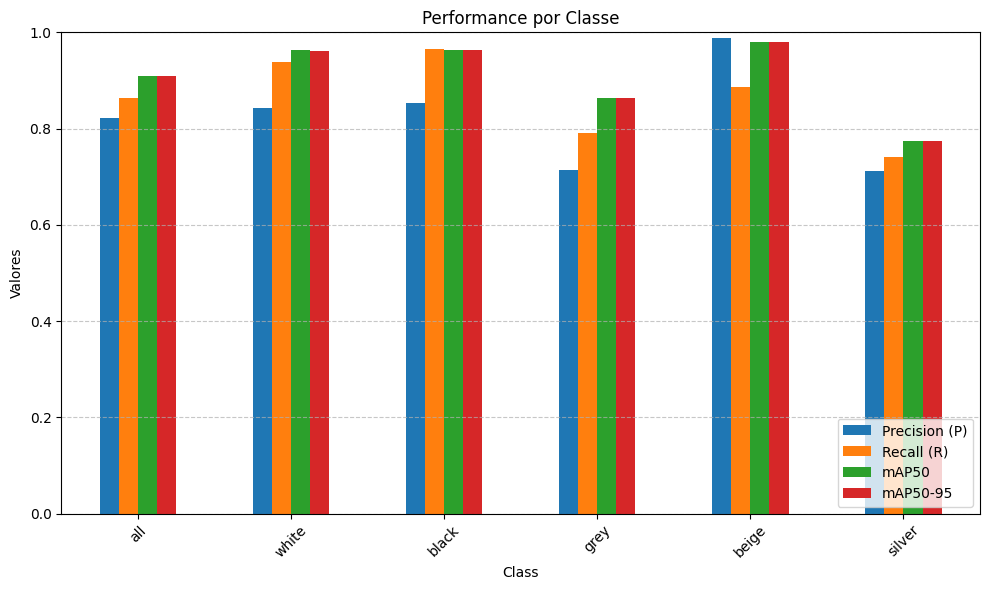

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados
data = {
    "Class": ["all", "white", "black", "grey", "beige", "silver"],
    "Precision (P)": [0.822, 0.843, 0.853, 0.713, 0.988, 0.712],
    "Recall (R)": [0.864, 0.939, 0.965, 0.791, 0.886, 0.740],
    "mAP50": [0.909, 0.963, 0.964, 0.864, 0.980, 0.774],
    "mAP50-95": [0.909, 0.962, 0.964, 0.863, 0.980, 0.774]
}

# Convertendo para DataFrame
df = pd.DataFrame(data)

# Gráficos para Precision, Recall e mAP
metrics = ["Precision (P)", "Recall (R)", "mAP50", "mAP50-95"]
df.set_index("Class")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Performance por Classe")
plt.ylabel("Valores")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### 15 Epocas

In [ ]:
#pip install ultralytics

from ultralytics import YOLO

#carregar modelo pré treinado
model = YOLO('yolov8n.pt')
#caminho do yaml
data_yaml_path = "yolo_dataset/data.yaml"

#treinar o modelo
model.train(
    data=data_yaml_path,
    epochs=15,
    imgsz=320,
    batch=32
)

#Avaliar o modelo no conjunto de teste
metrics = model.val(data=data_yaml_path)

#salvar o modelo
model.save('C:/Users/guilh/OneDrive/Documentos/GitHub/car-color-recognition/models/vehicle_car_color_yolov8nV2.pt')

# Mostrar métricas
print("Avaliação no conjunto de teste:")
print(metrics)

Ultralytics 8.3.70  Python-3.12.7 torch-2.6.0+cpu CPU (Intel Xeon E5-2650 v2 2.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=15, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\notebooks\yolo_dataset\labels\train... 4535 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4535/4535 [00:06<00:00, 699.85it/s]


train: New cache created: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\notebooks\yolo_dataset\labels\train.cache


val: Scanning C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\notebooks\yolo_dataset\labels\val... 966 images, 0 backgrounds, 1 corrupt: 100%|██████████| 967/967 [00:01<00:00, 723.26it/s]


val: WARNING  C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\notebooks\yolo_dataset\images\val\0b2ca4bb14.jpg: ignoring corrupt image/label: image size (7, 10) <10 pixels
val: New cache created: C:\Users\guilh\OneDrive\Documentos\GitHub\car-color-recognition\notebooks\yolo_dataset\labels\val.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15         0G     0.3076      2.153     0.9561         72        320: 100%|██████████| 142/142 [10:27<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]

                   all        966        966      0.725      0.804      0.797       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15         0G     0.2031     0.9102     0.8994         70        320: 100%|██████████| 142/142 [10:26<00:00,  4.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.95s/it]

                   all        966        966      0.765      0.803      0.868      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15         0G     0.1858     0.8063     0.8859         78        320: 100%|██████████| 142/142 [11:02<00:00,  4.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.99s/it]

                   all        966        966      0.731      0.838      0.847      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15         0G      0.178     0.7534     0.8812         65        320: 100%|██████████| 142/142 [10:58<00:00,  4.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:31<00:00,  1.98s/it]

                   all        966        966      0.768      0.869      0.878      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15         0G     0.1613     0.6803     0.8735         74        320: 100%|██████████| 142/142 [10:51<00:00,  4.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:30<00:00,  1.93s/it]

                   all        966        966       0.78       0.82      0.896      0.894


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15         0G     0.1556     0.6636      0.861         23        320: 100%|██████████| 142/142 [10:21<00:00,  4.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.87s/it]

                   all        966        966      0.749      0.737      0.832      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15         0G     0.1271     0.5606     0.8538         23        320: 100%|██████████| 142/142 [10:02<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]

                   all        966        966      0.765      0.865      0.875      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15         0G      0.114     0.4786     0.8488         23        320: 100%|██████████| 142/142 [09:44<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.84s/it]

                   all        966        966      0.796      0.897      0.899      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15         0G     0.1059     0.4266     0.8442         23        320: 100%|██████████| 142/142 [09:48<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]

                   all        966        966      0.876      0.909      0.945      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15         0G    0.09669     0.4027     0.8394         23        320: 100%|██████████| 142/142 [10:05<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:28<00:00,  1.79s/it]

                   all        966        966      0.881      0.894      0.943      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15         0G    0.08819     0.3612     0.8382         23        320: 100%|██████████| 142/142 [10:09<00:00,  4.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:28<00:00,  1.78s/it]

                   all        966        966      0.909      0.877      0.942      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15         0G    0.07776     0.3414     0.8392         23        320: 100%|██████████| 142/142 [09:50<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]

                   all        966        966      0.891      0.917      0.944      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15         0G    0.07217      0.298     0.8338         23        320: 100%|██████████| 142/142 [10:03<00:00,  4.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.87s/it]

                   all        966        966      0.883      0.886      0.932      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15         0G    0.06648     0.2822     0.8298         32        320:  69%|██████▉   | 98/142 [06:57<03:18,  4.51s/it]

Graficos 15 epocas

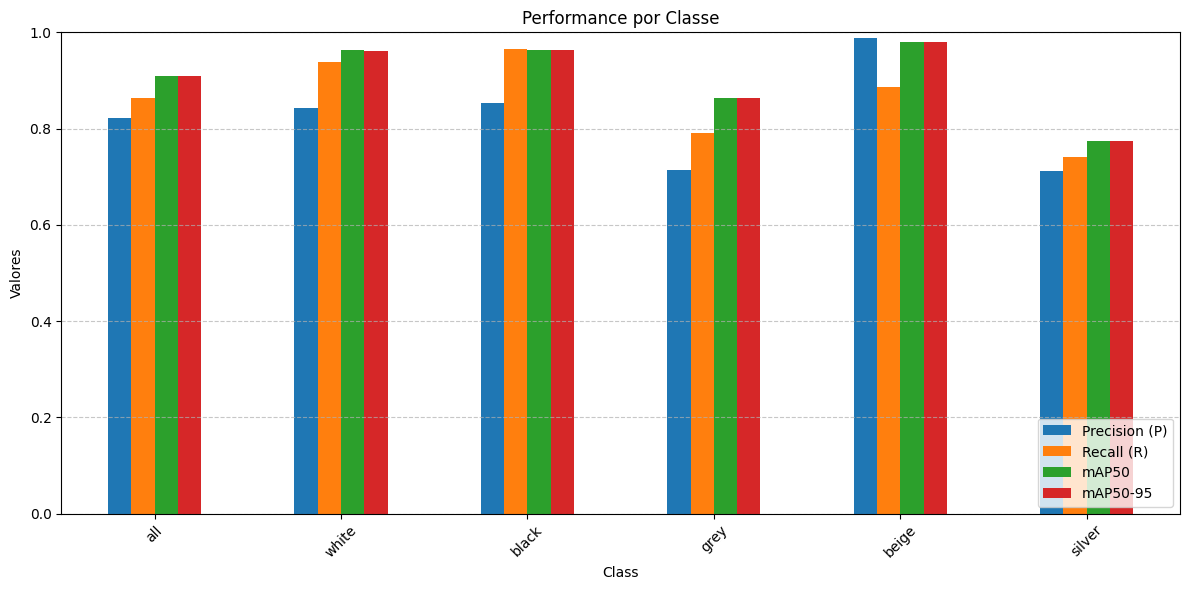

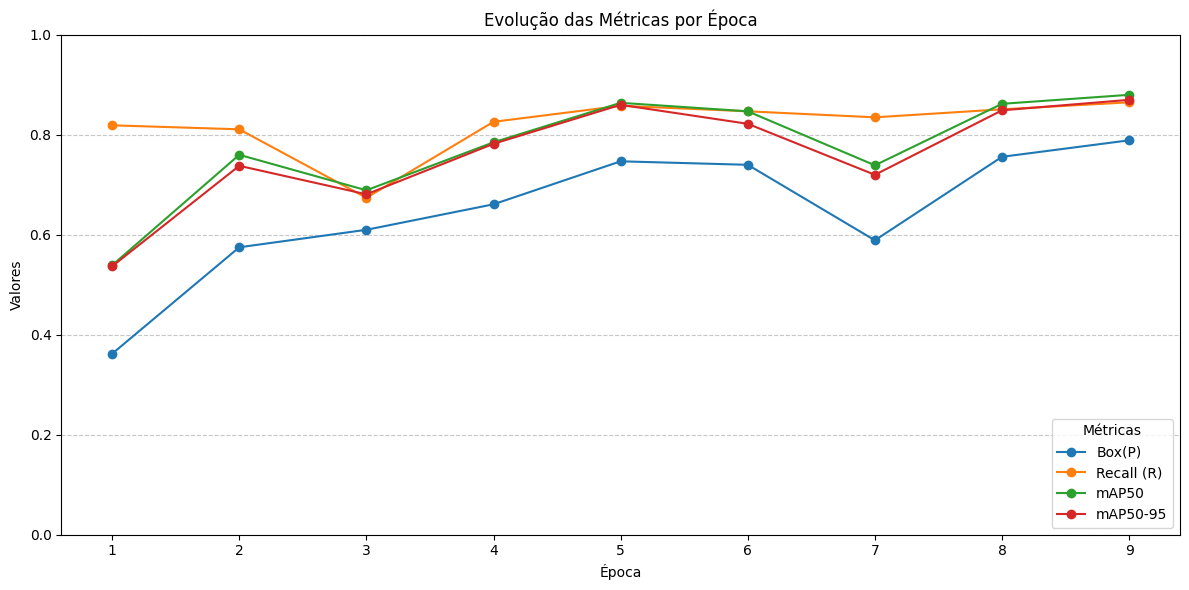

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dados extraídos do treinamento do YOLOv8
data = {
    "Class": ["all", "white", "black", "grey", "beige", "silver"],
    "Precision (P)": [0.822, 0.843, 0.853, 0.713, 0.988, 0.712],
    "Recall (R)": [0.864, 0.939, 0.965, 0.791, 0.886, 0.740],
    "mAP50": [0.909, 0.963, 0.964, 0.864, 0.980, 0.774],
    "mAP50-95": [0.909, 0.962, 0.964, 0.863, 0.980, 0.774]
}

# Resultados do treinamento por época
training_epochs = {
    "Epoch": list(range(1, 10)),
    "Box(P)": [0.362, 0.575, 0.610, 0.661, 0.747, 0.740, 0.589, 0.756, 0.789],
    "Recall (R)": [0.819, 0.811, 0.674, 0.826, 0.858, 0.847, 0.835, 0.851, 0.865],
    "mAP50": [0.539, 0.760, 0.689, 0.785, 0.864, 0.847, 0.739, 0.862, 0.880],
    "mAP50-95": [0.537, 0.738, 0.681, 0.782, 0.860, 0.822, 0.720, 0.849, 0.870]
}

# Convertendo para DataFrames
df_metrics = pd.DataFrame(data)
df_epochs = pd.DataFrame(training_epochs)

# Plot 1: Performance por Classe
metrics = ["Precision (P)", "Recall (R)", "mAP50", "mAP50-95"]
df_metrics.set_index("Class")[metrics].plot(kind="bar", figsize=(12, 6))
plt.title("Performance por Classe")
plt.ylabel("Valores")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Evolução das métricas por época
df_epochs.set_index("Epoch").plot(figsize=(12, 6), marker="o")
plt.title("Evolução das Métricas por Época")
plt.ylabel("Valores")
plt.ylim(0, 1)
plt.xlabel("Época")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Métricas", loc="lower right")
plt.tight_layout()
plt.show()

#Criação da Interface

In [ ]:
!pip install streamlit
!pip install pyngrok

In [ ]:
import os

# Obter o caminho absoluto do arquivo salvo
saved_model_path = os.path.abspath('vehicle_car_color_yolov8n.pt')
print(f"O modelo foi salvo em: {saved_model_path}")

O modelo foi salvo em: /content/vehicle_car_color_yolov8n.pt


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
from ultralytics import YOLO

# Carregue o modelo
model = YOLO("/content/vehicle_car_color_yolov8n.pt")  # Substitua pelo seu modelo treinado

st.title("Reconhecimento de Cores de Carros")
st.write("Este projeto utiliza YOLOv8 para detectar e classificar cores de carros.")

# Upload de imagem
uploaded_file = st.file_uploader("Carregue uma imagem", type=["jpg", "jpeg", "png"])

if uploaded_file:
    # Exiba a imagem carregada
    image = Image.open(uploaded_file)
    st.image(image, caption="Imagem carregada", use_column_width=True)

    # Faça a predição
    st.write("Processando a imagem...")
    results = model(image)

    # Exiba os resultados
    st.write("### Resultados:")
    for r in results:
        for box in r.boxes:
            # Converta o tensor para um valor numérico
            st.write(f"Classe: {int(box.cls)}, Confiança: {float(box.conf):.2f}")


    # Visualize a imagem com predições
    annotated_image = results[0].plot()
    st.image(annotated_image, caption="Predições do modelo", use_column_width=True)

Overwriting app.py


In [ ]:
%%writefile app.py
import streamlit as st
from PIL import Image
from ultralytics import YOLO

# Carregue o modelo
model = YOLO("/content/vehicle_car_color_yolov8nV2.pt")  # Substitua pelo seu modelo treinado

st.title("Reconhecimento de Cores de Carros")
st.write("Este projeto utiliza YOLOv8 para detectar e classificar cores de carros.")

# Upload de imagem
uploaded_file = st.file_uploader("Carregue uma imagem", type=["jpg", "jpeg", "png"])

if uploaded_file:
    # Exiba a imagem carregada
    image = Image.open(uploaded_file)
    st.image(image, caption="Imagem carregada", use_column_width=True)

    # Faça a predição
    st.write("Processando a imagem...")
    results = model(image)

    # Exiba os resultados
    st.write("### Resultados:")
    for r in results:
        for box in r.boxes:
            # Converta o tensor para um valor numérico
            st.write(f"Classe: {int(box.cls)}, Confiança: {float(box.conf):.2f}")


    # Visualize a imagem com predições
    annotated_image = results[0].plot()
    st.image(annotated_image, caption="Predições do modelo", use_column_width=True)

Overwriting app.py


In [ ]:
!ngrok authtoken 2rd6NsrH7xdSIz7EhzeJBEog8ge_heE8HF2r7WWNNXYy2pJZ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Cria um túnel para a porta padrão do Streamlit (8501)
public_url = ngrok.connect(8501)
print('Acesse o app através do link:', public_url)

Acesse o app através do link: NgrokTunnel: "https://33ba-34-106-224-148.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.2:8501
  External URL: http://34.106.224.148:8501

2025-01-15 00:04:31.934 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registered via torch::class_
2025-01-15 00:04:39.680 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.

0: 192x320 1 grey, 53.8ms
Speed: 1.5ms preprocess, 53.8ms inference, 2.2ms postprocess per image at shape (1, 3, 192, 320)
2025-01-15 00:04:40.626 The `use_column_width` parameter has been deprecated and will be removed in a future release. Please utilize the `use_container_width` parameter instead.
2025-01-15 00:04:40.864 Examining the path of torch.classes raised: Tried to instantiate class '__path__._path', but it does not exist! Ensure that it is registe